In [1]:
!pip install equiflow


In [31]:
import pandas as pd
from tableone import TableOne
import sklearn as sk
from xgboost import XGBClassifier, XGBRegressor
import numpy as np
from scipy.stats import ttest_ind, chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import chi2_contingency

from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    average_precision_score,
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    balanced_accuracy_score
)
from sklearn.utils import resample
from sklearn.metrics import r2_score, mean_absolute_error
from fairlearn.metrics import equalized_odds_ratio, demographic_parity_ratio
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
import warnings
import shap
from tableone import tableone
from matplotlib import pyplot as plt
import pydata_google_auth
import seaborn as sns
import pandas_gbq
from equiflow import EquiFlow

warnings.filterwarnings("ignore")

In [5]:
credentials = pydata_google_auth.get_user_credentials(['https://www.googleapis.com/auth/cloud-platform'],)
project = 'capacheiv'
pandas_gbq.context.credentials = credentials

In [8]:
query = ""
for fn in ['icustays', 'apache_vars', 'apache_pt_results', 'sepsis']:
    with open('eicu_1/'+fn+'.sql', 'r') as file:
        query += file.read()
query += "select * from sepsis"
project = 'capacheiv'

df_o = pd.read_gbq(query, dialect='standard', project_id=project)

/var/folders/xm/mdh1z4bd7h9by6kx3f382gpw0000gn/T/ipykernel_5413/1379506980.py:8: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  df_o = pd.read_gbq(query, dialect='standard', project_id=project)


In [11]:
query = ""
for fn in ['icustays', 'apache_vars', 'apache_pt_results', 'sepsis']:
    with open('eicu_2/'+fn+'.sql', 'r') as file:
        query += file.read()
query += "select * from sepsis"
project = 'capacheiv'

df_n = pd.read_gbq(query, dialect='standard', project_id=project)

/var/folders/xm/mdh1z4bd7h9by6kx3f382gpw0000gn/T/ipykernel_5413/3029766810.py:8: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  df_n = pd.read_gbq(query, dialect='standard', project_id=project)


In [12]:
df_n_no_duplicates = df_n[~df_n['uniquepid'].isin(df_o['uniquepid'])] 

In [13]:
df = pd.concat([df_o, df_n_no_duplicates], axis=0, ignore_index=True)

In [14]:
eicu1 = pd.read_csv("files/sepsis_adult_eicu_v1.csv")
eicu2 = pd.read_csv("files/sepsis_adult_eicu_v2.csv")

xai_df_sepsis = pd.concat([eicu1, eicu2], axis=0, ignore_index=True)

In [15]:
df = df.dropna(subset=['ethnicity'])
df = df[(df['ethnicity'] != '')]


In [68]:
df['ethnicity'] = df['ethnicity'].replace({'Black/African American': 'African American',
                                           '': 'Other/Unknown/Missing',
                                           'Native American':'Indigenous/Native',
                                           'Other/Unknown':'Other/Unknown/Missing'})
df['age_num'] = df['age_num'].astype(float)
df['ApacheScore'] = df['ApacheScore'].astype(float)
df['daysonvent'] = df['daysonvent'].astype(float)


df['gender'] = df['gender'].replace({ '': 'Unknown'})
df = df.fillna({'ethnicity':'Other/Unknown/Missing', 'gender':'Unknown'})
df = df.rename(columns = {'has_sepsis':'Sepsis', 'HOSP_NUM':'Number_of_Admissions', 'hospitaldischargeyear':'Discharge_Year',
                            'hosp_mortality':'hospital_mortality'})

df['set'] = df['Discharge_Year'].apply(
    lambda x: '2014-2015' if x in [2014, 2015] else(
              '2020-2021' if x in [2020, 2021] else np.nan
    ))


df['age_bins'] = pd.cut(
    df['age_num'],
    bins=[0, 44, 64, 76, np.inf],
    labels=['19–44', '45–64', '65-77', '>79']
)

In [32]:
columns = ['gender', 'age_num', 'ethnicity', 'age_bins', 'ApacheScore', 'Apache_Version',
           'predicted_hospital_mortality', 'mortality']

categorical = ['gender', 'ethnicity', 'age_bins' ,'Apache_Version', 'mortality',]

table1 = TableOne(data=df,
                  columns=columns,
                  categorical=categorical,
                  groupby='hospital_mortality',  
                  isnull=True,
                  pval=True)  

table1

Grouped by hospital_mortality                                                      
                                                                                    Missing        Overall               0              1 P-Value
n                                                                                                   385956          218363          26257        
gender, n (%)                           Female                                            0  173804 (45.0)    98728 (45.2)   11787 (44.9)   0.007
                                        Male                                                 212050 (54.9)   119609 (54.8)   14460 (55.1)        
                                        Other                                                      7 (0.0)         4 (0.0)        1 (0.0)        
                                        Unknown                                                   95 (0.0)        22 (0.0)        9 (0.0)        
age_num, mean (SD)                                                                        2    63.2 (16.9)     62.5 (17.0)    69.1 (14.6)  <0.001
ethnicity, n (%)                        African American                                  0   41688 (10.8)    25891 (11.9)    2820 (10.7)  <0.001
                                        Asian                                                   7206 (1.9)      3098 (1.4)      406 (1.5)        
                                        Caucasian                                            293481 (76.0)   166843 (76.4)   20037 (76.3)        
                                        Hispanic                                               14902 (3.9)      8628 (4.0)     1079 (4.1)        
                                        Indigenous/Native                                       3830 (1.0)      1390 (0.6)      169 (0.6)        
                                        Other/Unknown/Missing                                  24849 (6.4)     12513 (5.7)     1746 (6.6)        
age_bins, n (%)                         19–33                                            27    26860 (7.0)     16273 (7.5)      643 (2.4)  <0.001
                                        34–48                                                 44589 (11.6)    26565 (12.2)     1686 (6.4)        
                                        49–64                                                114111 (29.6)    66887 (30.6)    6555 (25.0)        
                                        65-77                                                108139 (28.0)    59610 (27.3)    8095 (30.8)        
                                        >79                                                   92230 (23.9)    49019 (22.4)    9278 (35.3)        
ApacheScore, mean (SD)                                                               141336    55.3 (26.4)     51.7 (22.9)    85.2 (33.7)  <0.001
Apache_Version, n (%)                   IV                                           141336   98971 (40.5)    89794 (41.1)    9177 (35.0)  <0.001
                                        IVa                                                   96418 (39.4)    85579 (39.2)   10839 (41.3)        
                                        IVb                                                   49231 (20.1)    42990 (19.7)    6241 (23.8)        
predicted_hospital_mortality, mean (SD)                                              141336      0.0 (0.4)       0.0 (0.3)      0.2 (0.5)  <0.001
mortality, n (%)                        0                                                 0  359699 (93.2)  218363 (100.0)                 <0.001
                                        1                                                      26257 (6.8)                  26257 (100.0)        
[1] Chi-squared tests for the following variables may be invalid due to the low number of observations: gender.

In [33]:
columns = ['gender', 'age_num', 'ethnicity', 'age_bins', 'ApacheScore', 'Apache_Version',
           'predicted_hospital_mortality', 'mortality']

categorical = ['gender', 'ethnicity', 'age_bins' ,'Apache_Version', 'mortality']
groupby = ['gender', 'age_bins', 'ethnicity']

table1 = TableOne(data=df,
                  columns=columns,
                  categorical=categorical,
                  groupby=groupby,  
                  isnull=True,
                  pval=True)  

table1

Grouped by gender                                                                                 
                                                                        Missing        Overall          Female            Male        Other      Unknown P-Value
n                                                                                       385956          173804          212050            7           95        
gender, n (%)                           Female                                0  173804 (45.0)  173804 (100.0)                                            <0.001
                                        Male                                     212050 (54.9)                  212050 (100.0)                                  
                                        Other                                          7 (0.0)                                    7 (100.0)                     
                                        Unknown                                       95 (0.0)                                                95 (100.0)        
age_num, mean (SD)                                                            2    63.2 (16.9)     64.0 (17.5)     62.6 (16.4)  47.0 (30.2)  63.4 (25.4)  <0.001
ethnicity, n (%)                        African American                      0   41688 (10.8)    20263 (11.7)    21417 (10.1)     3 (42.9)      5 (5.3)  <0.001
                                        Asian                                       7206 (1.9)      3177 (1.8)      4028 (1.9)                   1 (1.1)        
                                        Caucasian                                293481 (76.0)   131547 (75.7)   161873 (76.3)     2 (28.6)    59 (62.1)        
                                        Hispanic                                   14902 (3.9)      6736 (3.9)      8164 (3.9)                   2 (2.1)        
                                        Indigenous/Native                           3830 (1.0)      1775 (1.0)      2055 (1.0)                                  
                                        Other/Unknown/Missing                      24849 (6.4)     10306 (5.9)     14513 (6.8)     2 (28.6)    28 (29.5)        
age_bins, n (%)                         19–33                                27    26860 (7.0)     12557 (7.2)     14286 (6.7)     3 (42.9)    14 (14.7)  <0.001
                                        34–48                                     44589 (11.6)    19359 (11.1)    25206 (11.9)     2 (28.6)    22 (23.2)        
                                        49–64                                    114111 (29.6)    47545 (27.4)    66554 (31.4)                 12 (12.6)        
                                        65-77                                    108139 (28.0)    47178 (27.1)    60956 (28.7)                   5 (5.3)        
                                        >79                                       92230 (23.9)    47152 (27.1)    45034 (21.2)     2 (28.6)    42 (44.2)        
ApacheScore, mean (SD)                                                   141336    55.3 (26.4)     55.7 (26.1)     54.9 (26.7)  39.0 (27.0)  70.1 (39.5)  <0.001
Apache_Version, n (%)                   IV                               141336   98971 (40.5)    44901 (40.6)    54051 (40.3)     3 (60.0)    16 (51.6)   0.002
                                        IVa                                       96418 (39.4)    43755 (39.6)    52648 (39.3)     2 (40.0)    13 (41.9)        
                                        IVb                                       49231 (20.1)    21859 (19.8)    27370 (20.4)                   2 (6.5)        
predicted_hospital_mortality, mean (SD)                                  141336      0.0 (0.4)       0.0 (0.4)       0.0 (0.4)   -0.0 (0.6)    0.4 (0.5)  <0.001
mortality, n (%)                        0                                     0  359699 (93.2)   162017 (93.2)   197590 (93.2)     6 (85.7)    86 (90.5)   0.594
                                     

In [37]:
df_sepsis['ethnicity'].value_counts()

ethnicity
Caucasian    12487
Hispanic       726
Asian          233
Name: count, dtype: int64

In [92]:
# Hamza: This table is to see how many patients are in each sub-group, patients  with Alive or Expired values = 0 in either years cannot
# have their AUROC's computed, thus are not represented in our data

table = (
    df_sepsis
    .groupby(['set','ethnicity', 'gender', 'age_bins'])['mortality']
    .value_counts()
    .unstack(fill_value=0)
    .reset_index()
    .rename(columns={0: 'Alive', 1: 'Expired'})
)

table

mortality,set,ethnicity,gender,age_bins,Alive,Expired
0,2014-2015,African American,Female,19–44,108,10
1,2014-2015,African American,Female,45–64,247,38
2,2014-2015,African American,Female,65-77,116,23
3,2014-2015,African American,Female,>79,92,28
4,2014-2015,African American,Male,19–44,119,12
5,2014-2015,African American,Male,45–64,260,38
6,2014-2015,African American,Male,65-77,141,37
7,2014-2015,African American,Male,>79,87,23
8,2014-2015,African American,Unknown,19–44,0,0
9,2014-2015,African American,Unknown,45–64,0,0


In [69]:
df_sepsis = df[df.hospital_mortality.notna()]
df_sepsis = df_sepsis[df_sepsis.ApacheScore.notna()]
df_sepsis = df[(df['Sepsis'] == 1) | (df['patientunitstayid'].isin(xai_df_sepsis['patientunitstayid']))]
df_sepsis = df_sepsis[df_sepsis.Number_of_Admissions == 1]
df_sepsis = df_sepsis[df_sepsis.predicted_hospital_mortality >= 0]
df_sepsis = df_sepsis[df_sepsis.Apache_Version == 'IV']
#inlcuded these four races, the rest are too small to cut down even further
df_sepsis = df_sepsis[(df_sepsis['ethnicity'] == 'Caucasian') | (df_sepsis['ethnicity']=='African American') | (df_sepsis['ethnicity'] == 'Asian') | (df_sepsis['ethnicity']=='Hispanic')]

In [93]:
#calculates drop in AUROC between 2014-2015 and 2020-2021
def bootstrap_auroc_diff(df, nboot=4000):
    results = []

    for ethnicity in df['ethnicity'].unique():
        for age_bin in df['age_bins'].unique():
            for gender in df['gender'].unique():

                subset = df[
                    (df['ethnicity'] == ethnicity) &
                    (df['age_bins'] == age_bin) &
                    (df['gender'] == gender)
                ]

                df_2014 = subset[subset['set'] == '2014-2015']
                df_2020 = subset[subset['set'] == '2020-2021']

                if df_2014.empty or df_2020.empty:
                    continue

                y_true_2014 = df_2014['mortality'].values
                y_pred_2014 = df_2014['predicted_hospital_mortality'].values
                y_true_2020 = df_2020['mortality'].values
                y_pred_2020 = df_2020['predicted_hospital_mortality'].values

                n_2014, n_2020 = len(y_true_2014), len(y_true_2020)
                diffs = []

                for _ in range(nboot):
                    idx_2014 = np.random.randint(0, n_2014, n_2014)
                    idx_2020 = np.random.randint(0, n_2020, n_2020)

                    y_true_2014_bs = y_true_2014[idx_2014]
                    y_pred_2014_bs = y_pred_2014[idx_2014]
                    y_true_2020_bs = y_true_2020[idx_2020]
                    y_pred_2020_bs = y_pred_2020[idx_2020]

                    try:
                        auroc_2014 = roc_auc_score(y_true_2014_bs, y_pred_2014_bs)
                        auroc_2020 = roc_auc_score(y_true_2020_bs, y_pred_2020_bs)
                        diffs.append(auroc_2020 - auroc_2014)
                    except ValueError:
                        diffs.append(np.nan)

                diffs = np.array(diffs, dtype=float)
                valid_diffs = diffs[~np.isnan(diffs)]

                if len(valid_diffs) == 0:
                    mean_diff = np.nan
                    ci_lower = np.nan
                    ci_upper = np.nan
                else:
                    mean_diff = np.nanmean(valid_diffs)
                    ci_lower = np.nanpercentile(valid_diffs, 2.5)
                    ci_upper = np.nanpercentile(valid_diffs, 97.5)

                results.append({
                    'ethnicity': ethnicity,
                    'age_bins': age_bin,
                    'gender': gender,
                    'mean_diff_auroc': mean_diff,
                    'ci_lower': ci_lower,
                    'ci_upper': ci_upper,
                    'bootstrap_distribution': diffs
                })

    return pd.DataFrame(results)

auroc_diff_df = bootstrap_auroc_diff(df_sepsis, nboot=4000)


In [94]:
auroc_diff_df

,ethnicity,age_bins,gender,mean_diff_auroc,ci_lower,ci_upper,bootstrap_distribution
0,Caucasian,>79,Male,-0.014505,-0.081761,0.052562,"[0.030568625215225298, 0.026293504681478397, -..."
1,Caucasian,>79,Female,0.005975,-0.067253,0.075716,"[-0.0051122524897466715, -0.04415459362136953,..."
2,Caucasian,45–64,Male,-0.123498,-0.203098,-0.047540,"[-0.10811961170882767, -0.12542063870042597, -..."
3,Caucasian,45–64,Female,-0.077875,-0.155505,-0.005800,"[-0.11568370205733314, -0.06907581063620671, -..."
4,Caucasian,65-77,Male,-0.133422,-0.209949,-0.058938,"[-0.10699844816036908, -0.16161539213052145, -..."
5,Caucasian,65-77,Female,-0.063599,-0.150023,0.021226,"[-0.0274023020901204, -0.0679729582226446, -0...."
6,Caucasian,19–44,Male,-0.005056,-0.150570,0.133129,"[-0.08328714518127711, 0.07117924318555746, 0...."
7,Caucasian,19–44,Female,-0.014513,-0.125533,0.084874,"[-0.09581002145008655, -0.09232043921310695, -..."
8,Hispanic,>79,Male,-0.126203,-0.432911,0.102142,"[0.02102402745995413, -0.12484126984126998, -0..."
9,Hispanic,>79,Female,-0.233238,-0.505053,0.038070,"[-0.21582806573957014, -0.2508089639232238, -0..."


In [60]:
def bootstrap_smr_diff(df, nboot=4000):
    results = []

    for ethnicity in df['ethnicity'].unique():
        for age_bin in df['age_bins'].unique():
            for gender in df['gender'].unique():

                subset = df[
                    (df['ethnicity'] == ethnicity) &
                    (df['age_bins'] == age_bin) &
                    (df['gender'] == gender)
                ]

                df_2014 = subset[subset['set'] == '2014-2015']
                df_2020 = subset[subset['set'] == '2020-2021']

                # Skip empty groups
                if df_2014.empty or df_2020.empty:
                    continue

                obs_2014 = df_2014['mortality'].values
                pred_2014 = df_2014['predicted_hospital_mortality'].values

                obs_2020 = df_2020['mortality'].values
                pred_2020 = df_2020['predicted_hospital_mortality'].values

                n_2014, n_2020 = len(obs_2014), len(obs_2020)
                diffs = []

                for _ in range(nboot):
                    bs_obs_2014, bs_pred_2014 = resample(obs_2014, pred_2014)
                    bs_obs_2020, bs_pred_2020 = resample(obs_2020, pred_2020)

                    exp_2014 = np.sum(bs_pred_2014)
                    exp_2020 = np.sum(bs_pred_2020)

                    obs_sum_2014 = np.sum(bs_obs_2014)
                    obs_sum_2020 = np.sum(bs_obs_2020)

                    if exp_2014 == 0 or exp_2020 == 0:
                        continue

                    smr_2014 = obs_sum_2014 / exp_2014
                    smr_2020 = obs_sum_2020 / exp_2020

                    diffs.append(abs(1-smr_2020) - abs(1-smr_2014))

                if len(diffs) == 0:
                    continue

                results.append({
                    'ethnicity': ethnicity,
                    'age_bins': age_bin,
                    'gender': gender,
                    'smr_2014': smr_2014,
                    'smr_2020': smr_2020,
                    'mean_diff_smr': np.mean(diffs),
                    'ci_lower': np.percentile(diffs, 2.5),
                    'ci_upper': np.percentile(diffs, 97.5),
                    'bootstrap_distribution': np.array(diffs)
                })

    return pd.DataFrame(results)


smr_diff_df = bootstrap_smr_diff(df_sepsis, nboot=4000)


In [61]:
smr_diff_df

,ethnicity,age_bins,gender,smr_2014,smr_2020,mean_diff_smr,ci_lower,ci_upper,bootstrap_distribution
0,Caucasian,>79,Male,0.982449,1.305174,0.198932,-0.023734,0.431721,"[0.2763619518519108, 0.10621741083976655, 0.26..."
1,Caucasian,>79,Female,0.825768,1.310350,0.026891,-0.175191,0.266291,"[0.03617066114636125, -0.10236390660730632, -0..."
2,Caucasian,49–64,Male,0.775352,1.211213,0.066726,-0.240663,0.432976,"[-0.041584049502092935, -0.08323317650119566, ..."
3,Caucasian,49–64,Female,0.718434,1.108045,-0.032419,-0.249083,0.312860,"[-0.2043041193235262, -0.20391252656547565, 0...."
4,Caucasian,65-77,Male,0.841490,1.115813,0.052395,-0.156576,0.329356,"[-0.051853684077499906, 0.10148581468282236, -..."
5,Caucasian,65-77,Female,0.859261,1.118803,0.033284,-0.140773,0.300949,"[-0.018501594938408417, -0.1150058646533938, -..."
6,Caucasian,34–48,Male,0.781299,0.918789,-0.118361,-0.425660,0.299064,"[-0.5330117875502889, 0.06673073280630426, 0.0..."
7,Caucasian,34–48,Female,0.539645,0.719762,-0.155719,-0.480223,0.296804,"[0.15058601468955302, 0.0028735065051546105, -..."
8,Caucasian,19–33,Male,0.674510,0.274647,0.251561,-0.211980,0.709750,"[0.05159364618752649, 0.33504391357072283, 0.3..."
9,Caucasian,19–33,Female,0.307107,1.218933,-0.265720,-0.693251,0.342522,"[-0.4395921085035551, -0.0663026070772782, -0...."


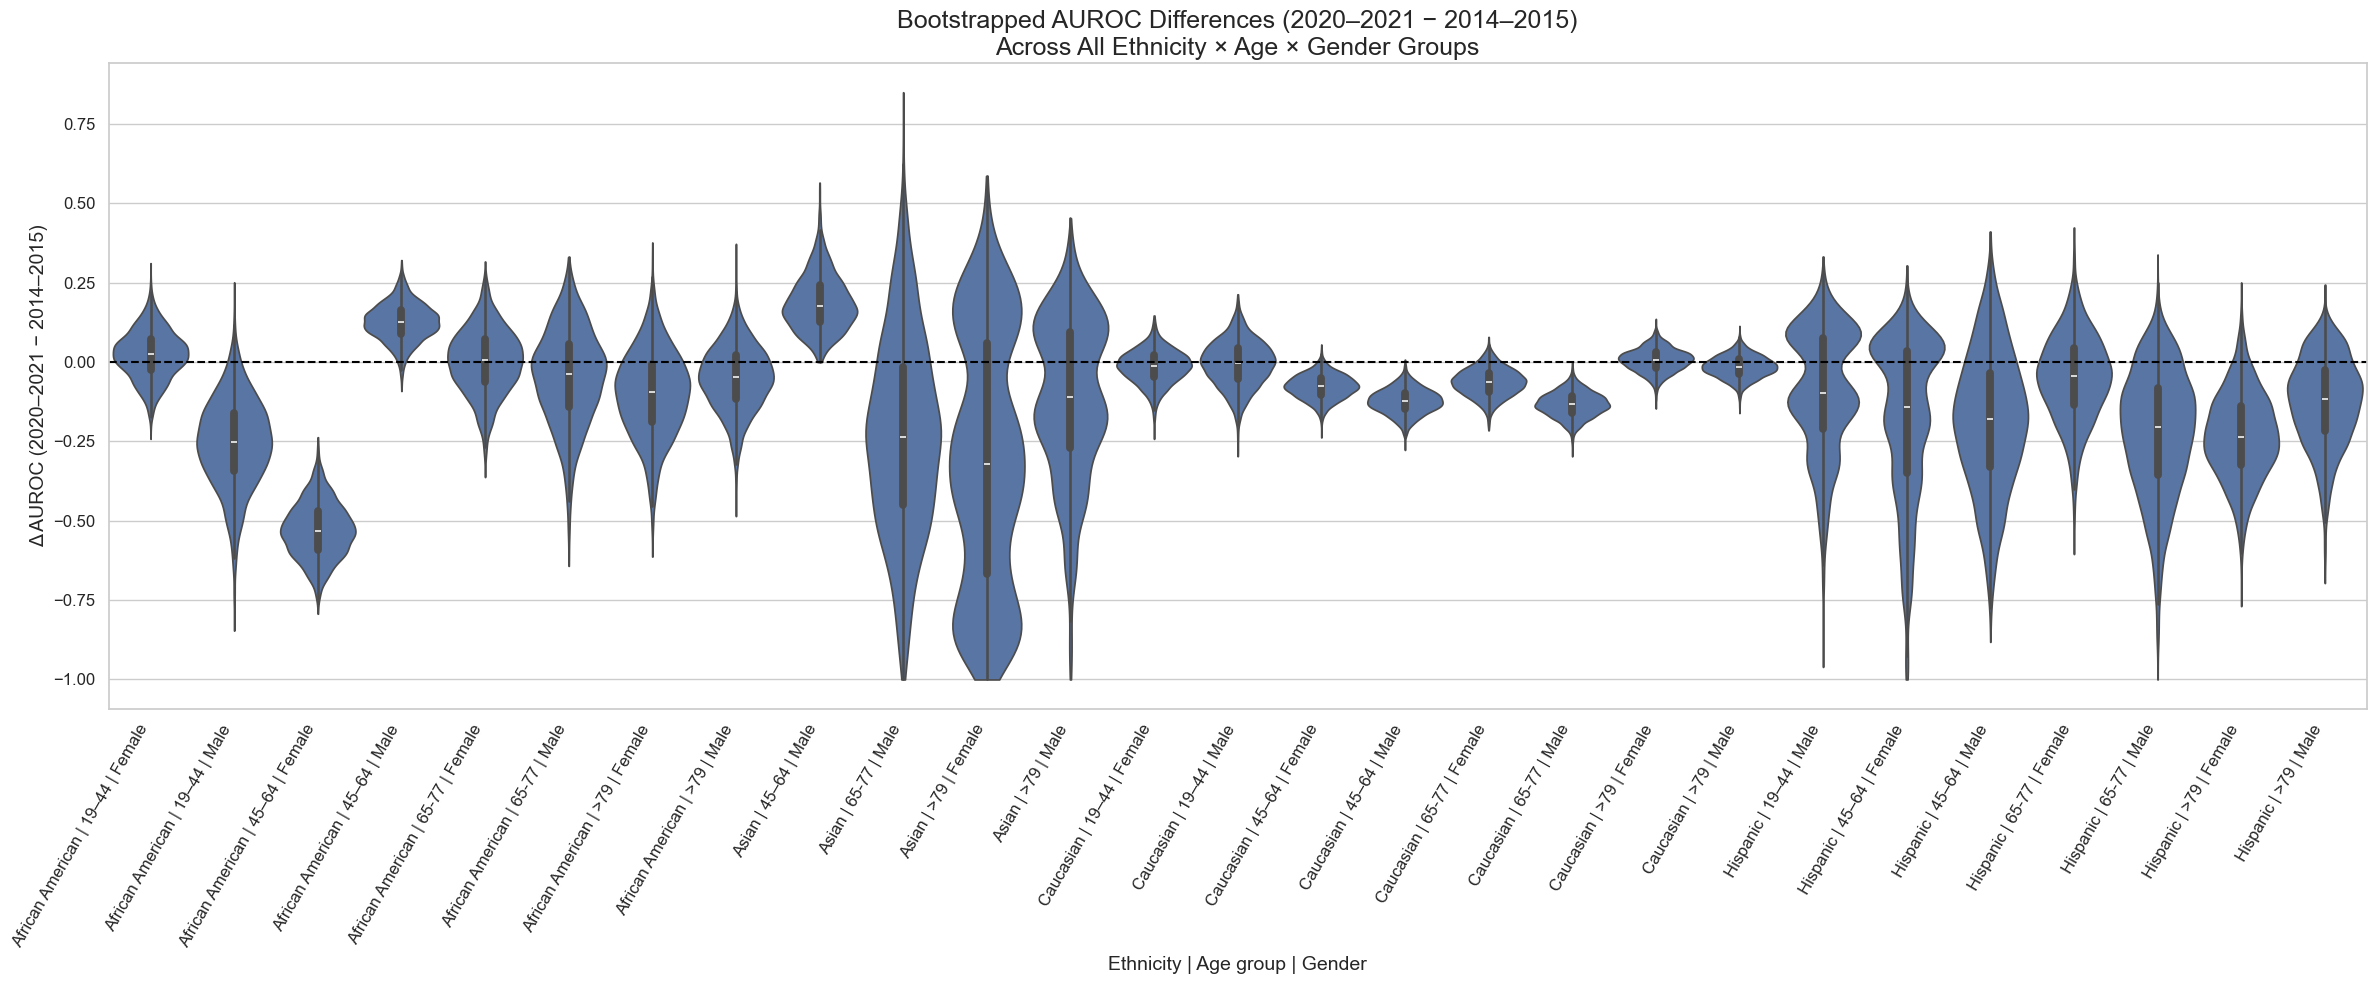

In [98]:
violin_df = (
    auroc_diff_df
    .explode('bootstrap_distribution')  
    .dropna(subset=['bootstrap_distribution'])  
    .copy()
)

violin_df['bootstrap_distribution'] = violin_df['bootstrap_distribution'].astype(float)


violin_df['group'] = (
    violin_df['ethnicity'].astype(str)
    + ' | ' + violin_df['age_bins'].astype(str)
    + ' | ' + violin_df['gender'].astype(str)
)


group_order = (
    auroc_diff_df
    .assign(group=lambda x: x['ethnicity'] + ' | ' + x['age_bins'] + ' | ' + x['gender'])
    .groupby('group')['mean_diff_auroc']
    .mean()
    .sort_values()
    .index
)

group_order = sorted(violin_df['group'].unique())

plt.figure(figsize=(24, 10))

sns.violinplot(
    data=violin_df,
    x='group',
    y='bootstrap_distribution',
    inner='box',
    cut=0,
    scale='width',
    order=group_order,
    width=0.9
)

plt.axhline(0, color='black', linestyle='--')
plt.title(
    'Bootstrapped AUROC Differences (2020–2021 − 2014–2015)\n'
    'Across All Ethnicity × Age × Gender Groups',
    fontsize=18
)
plt.ylabel('Δ AUROC (2020–2021 − 2014–2015)', fontsize=14)
plt.xlabel('Ethnicity | Age group | Gender', fontsize=14)

plt.xticks(rotation=60, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


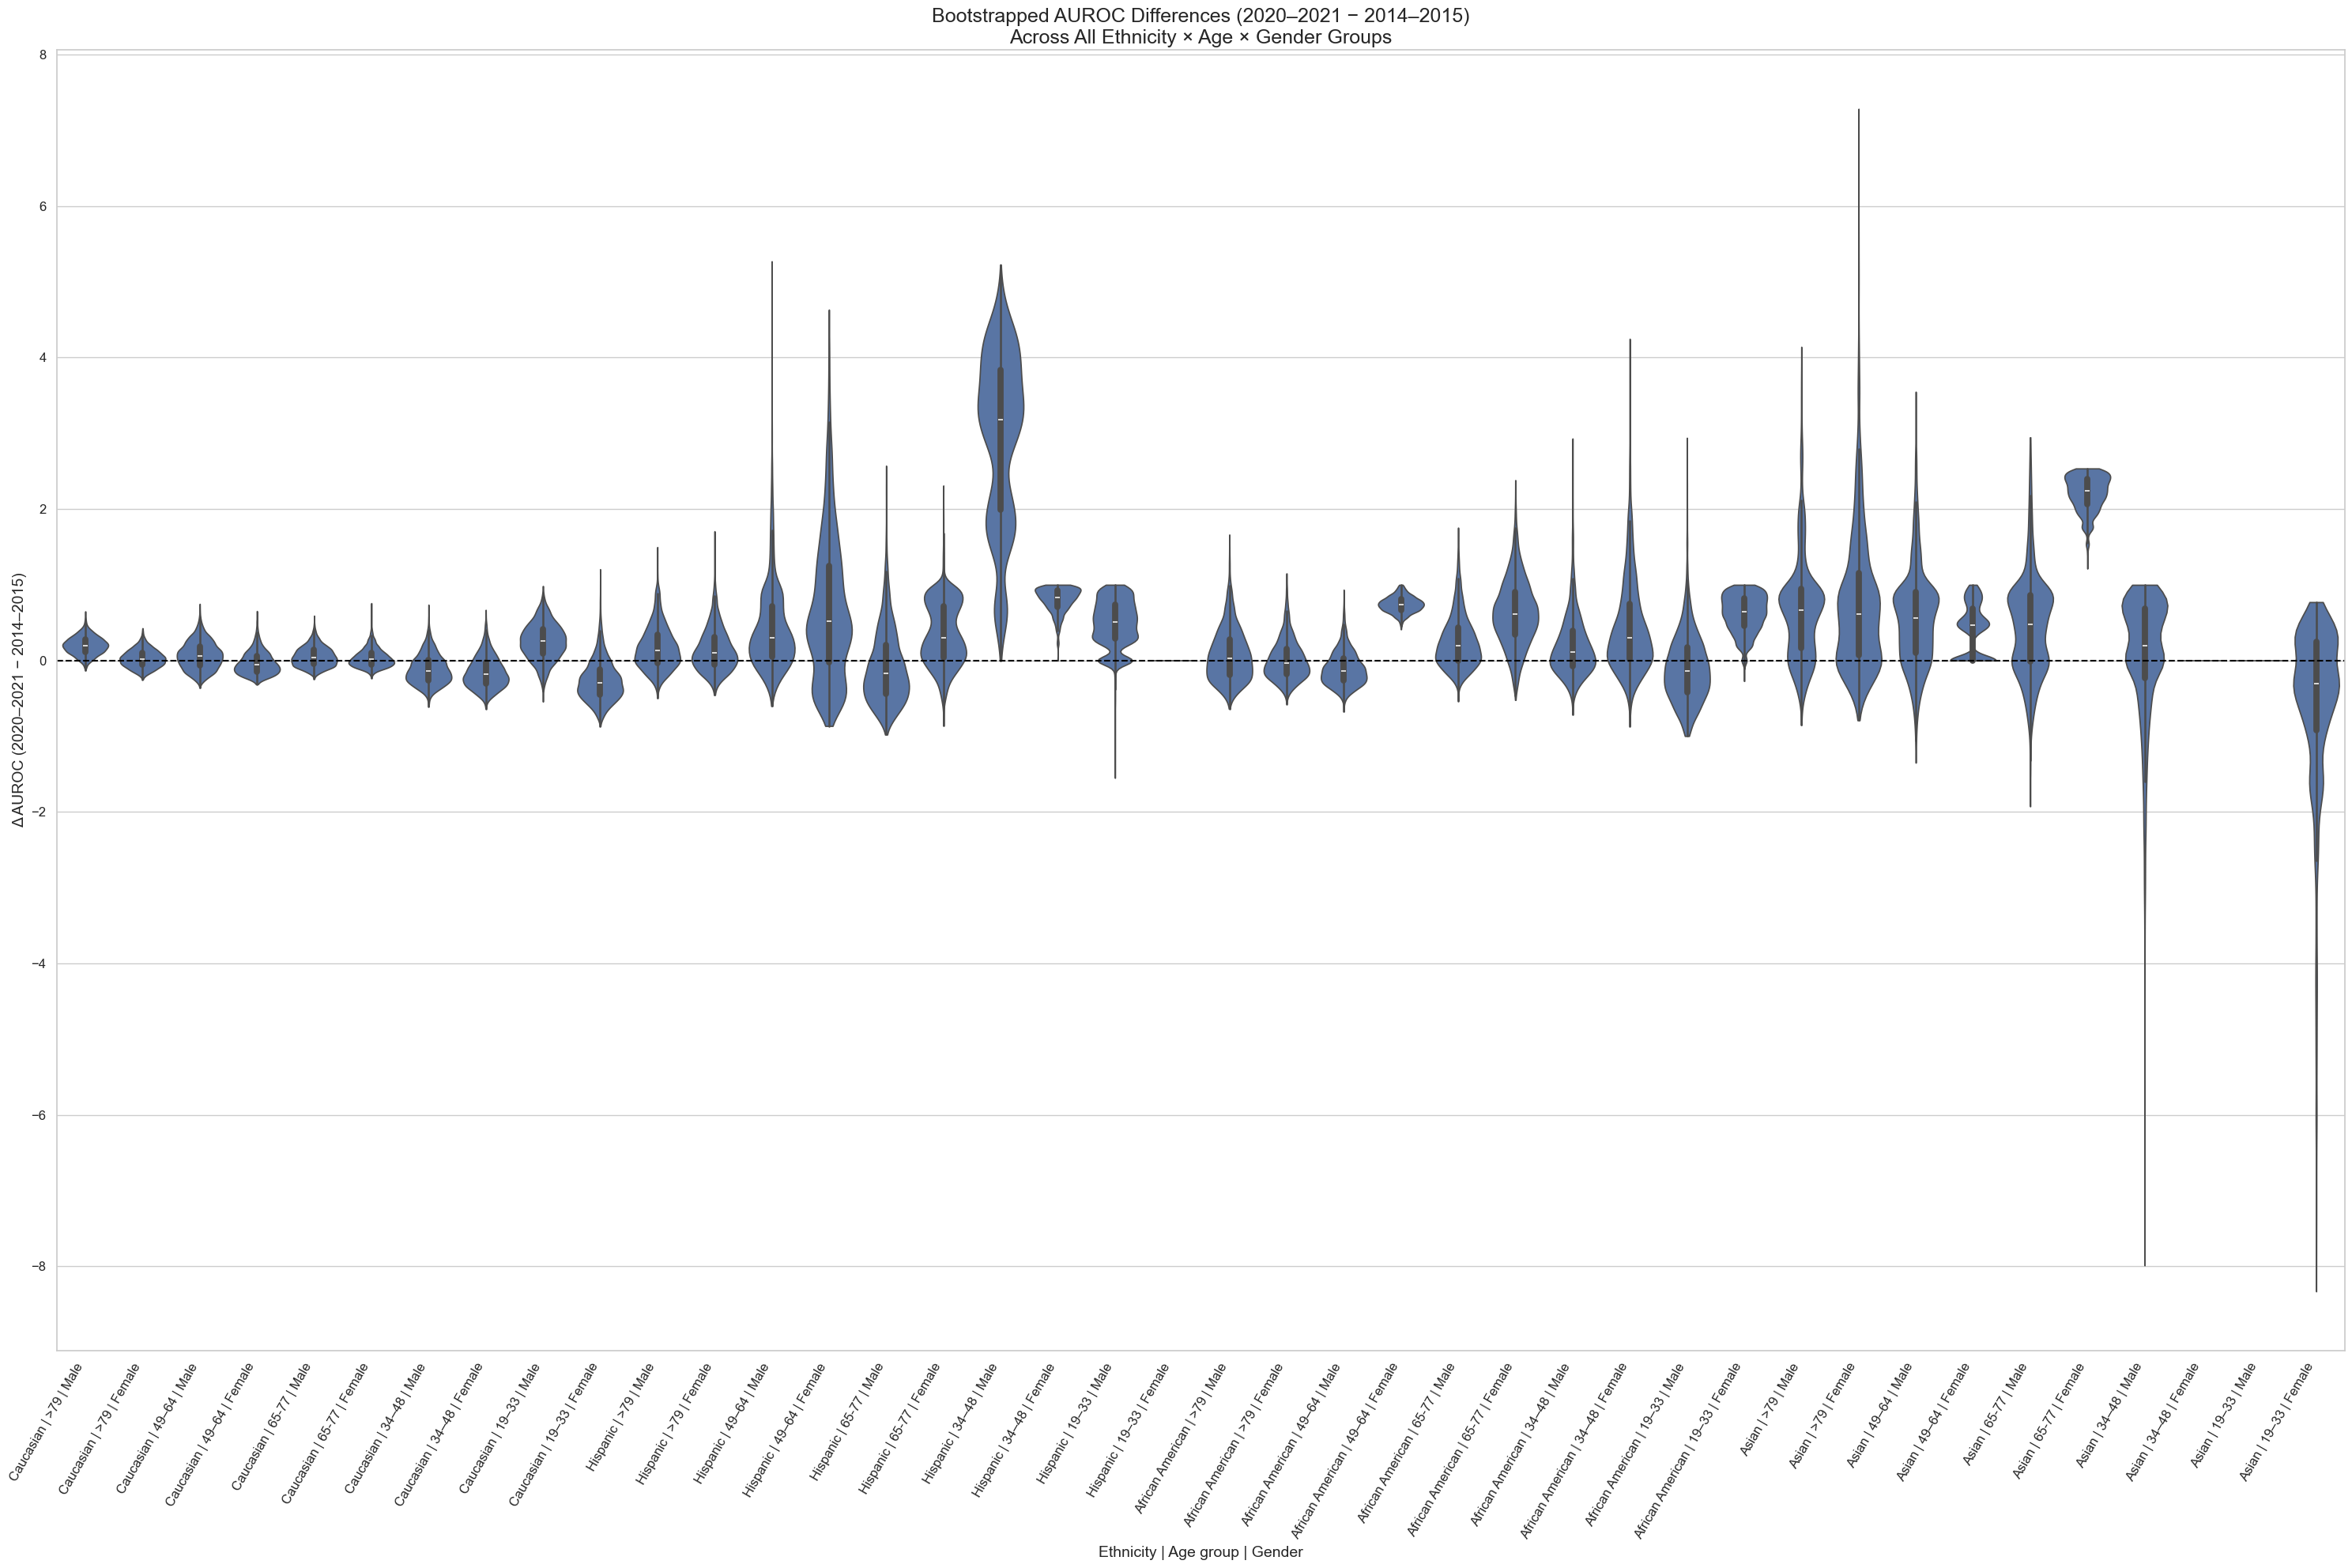

In [97]:


violin_df = smr_diff_df.explode('bootstrap_distribution')
violin_df['bootstrap_distribution'] = violin_df['bootstrap_distribution'].astype(float)

violin_df['group'] = violin_df['ethnicity'].astype(str) + ' | ' + \
                      violin_df['age_bins'].astype(str) + ' | ' + \
                      violin_df['gender'].astype(str)

plt.figure(figsize=(30, 20))  # wider and taller

sns.violinplot(
    data=violin_df,
    x='group',
    y='bootstrap_distribution',
    inner='box',      
    cut=0,          
    scale='width'     
)

plt.axhline(0, color='black', linestyle='--')
plt.title('Bootstrapped AUROC Differences (2020–2021 − 2014–2015)\nAcross All Ethnicity × Age × Gender Groups', fontsize=18)
plt.ylabel('Δ AUROC (2020–2021 − 2014–2015)', fontsize=14)
plt.xlabel('Ethnicity | Age group | Gender', fontsize=14)
plt.xticks(rotation=60, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()
